# Wavenet for time series prediction

In this tutorial, we show how to set up and train an WaveNet-based regression model with the deep4cast package. The dataset we're using is from the GEFCom2014 forecasting competition and involved hourly energy load forecasting.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from deep4cast.forecasters import Forecaster
import deep4cast.topologies as topologies

import deep4cast.custom_metrics as metrics
from pandas import read_table

%matplotlib inline

# Fix random number seed for reproducibility
np.random.seed(3) 

Using TensorFlow backend.


## Data preparation

In [2]:
# Load the data from file
filename = '../data/energy.csv'
df = read_table(filename, sep=',')

# Prepare the data set
data = df[['load', 'temp']].astype('float32').values
data = np.expand_dims(data, axis=0)

# We just need a small holdout dataset for evaluation purposes
holdout = 24 # hours
train_data = data[:,:-holdout,[0]]
test_data = data[:,-holdout:,[0]]

The time series below show hourly energy load data and hourly temperature data. We can use the temperature data as covariate for predicting the hourly load data into the future.

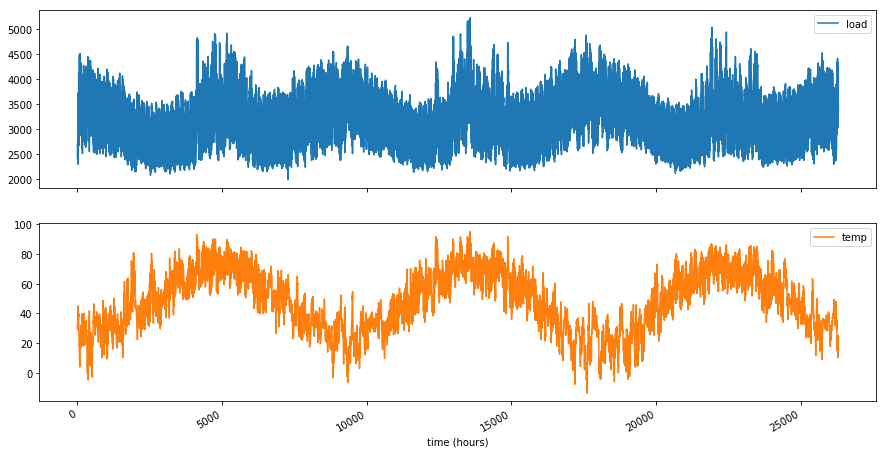

In [3]:
# Let plot the data
df.plot(subplots=True, figsize=(15, 8))
plt.xlabel('time (hours)')
plt.show()

# Modeling

Before we can fit a time series model, we need to specify a neural network topology that is suitable for this kind of time series. In this example, we opt for a WaveNet like topology that consists of stacked causal convolutional layers with residual connections.

In [4]:
topology = topologies.WaveNet(filters=32, num_layers=4)

In [5]:
forecaster = Forecaster(
    topology,
    lag=48,  # This is the number of time steps used to predict the future for each data point
    horizon=24,  # This is how many time steps into the future we want to produce
    lr=0.001,  # This is the learning rate for the optimizer
    patience=5
)

In [6]:
forecaster.fit(train_data, targets=[0], verbose=1)

Train on 23581 samples, validate on 2605 samples
Epoch 1/100
23581/23581 [==============================] - 21s 872us/step - loss: -0.0231 - val_loss: -1.0247
Epoch 2/100
23581/23581 [==============================] - 15s 653us/step - loss: -1.0240 - val_loss: -1.3701
Epoch 3/100
23581/23581 [==============================] - 16s 666us/step - loss: -1.2788 - val_loss: -1.5279
Epoch 4/100
23581/23581 [==============================] - 15s 653us/step - loss: -1.4436 - val_loss: -1.7173
Epoch 5/100
23581/23581 [==============================] - 16s 662us/step - loss: -1.5725 - val_loss: -1.7870
Epoch 6/100
23581/23581 [==============================] - 16s 671us/step - loss: -1.6739 - val_loss: -1.8843
Epoch 7/100
23581/23581 [==============================] - 16s 661us/step - loss: -1.7524 - val_loss: -1.8580
Epoch 8/100
23581/23581 [==============================] - 16s 660us/step - loss: -1.8103 - val_loss: -1.9259
Epoch 9/100
23581/23581 [==============================] - 15s 644us/st

We prevent overfitting of the model using early stopping when the validation set error stops imporoving. We use a patience parameters in the forecaster object to control when to stop.

Text(0,0.5,"['Loss', 'Validation Loss']")

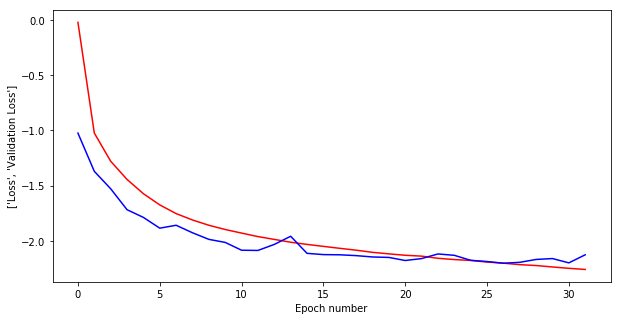

In [7]:
plt.figure(figsize=(10,5))
plt.plot(forecaster.history.epoch, forecaster.history.history['loss'], 'r')
plt.plot(forecaster.history.epoch, forecaster.history.history['val_loss'], 'b')
plt.xlabel('Epoch number')
plt.ylabel(['Loss', 'Validation Loss'])

# Evaluation

In [8]:
predictions = forecaster.predict(data=train_data, n_samples=1000)

One meaningful way of evaluating model performance is the Mean Absolute Percentage Error (MAPE), which we use here to see how well we are doing.

In [9]:
print('MSE: {}'.format(round(metrics.mse(predictions['mean'], test_data[:,:,:1]), 2)))
print('MAPE: {}%'.format(round(metrics.mape(predictions['mean'], test_data[:,:,:1]), 2)))
print('SMAPE: {}%'.format(round(metrics.smape(predictions['mean'], test_data[:,:,:1]), 2)))

MSE: 15163.87
MAPE: 2.34%
SMAPE: 2.3%


Lastly, we can check how our predictions compare with the data.

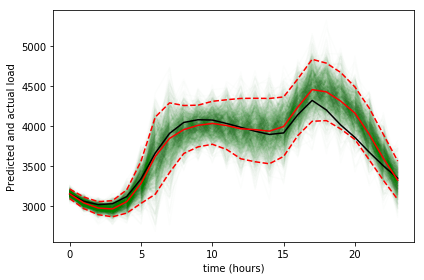

In [10]:
# We're printing the test set data and the predictions for the load data
plt.plot(predictions['samples'][:,0,:,0].T, 'g', alpha=0.01)
plt.plot(test_data[0,:,0].T, 'k')
plt.plot(predictions['mean'][0,:,0], 'r')
plt.plot(predictions['lower_quantile'][0,:,0], 'r--')
plt.plot(predictions['upper_quantile'][0,:,0], 'r--')
plt.xlabel('time (hours)')
plt.ylabel('Predicted and actual load')
plt.tight_layout()